In [1]:
%load_ext autoreload
%autoreload 2

import re
import time
import pickle
import numpy as np
# from edit_distance import SequenceMatcher
import torch
import matplotlib.pyplot as plt

from neural_decoder.dataset import SpeechDataset
from neural_decoder.neural_decoder_trainer import getDatasetLoaders, loadModel
from neural_decoder import lmDecoderUtils
# import neuralDecoder.utils.lmDecoderUtils as lmDecoderUtils

/home/rdgao/miniconda3/envs/nsd_test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
modelPath = "/home/rdgao/Documents/data/human_speech/logs/speech_logs/speechBaseline4/"
with open(modelPath + "/args", "rb") as handle:
    args = pickle.load(handle)

args['datasetPath'] = '/home/rdgao/Documents/data/human_speech/ptDecoder_ctc'

trainLoaders, testLoaders, loadedData = getDatasetLoaders(args["datasetPath"], args["batchSize"])

device = "cpu"
model = loadModel(modelPath, device=device)
model.eval()

rnn_outputs = {
    "logits": [],
    "logitLengths": [],
    "trueSeqs": [],
    "transcriptions": [],
}

/home/rdgao/miniconda3/envs/nsd_test/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Check model loss curves

Text(0.5, 1.0, 'Test CER')

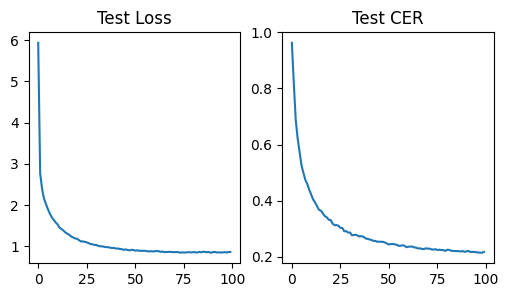

In [3]:
# Load training stats
with open(modelPath + "/trainingStats", "rb") as handle:
    trainingStats = pickle.load(handle)

fig,axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(trainingStats['testLoss']); axes[0].set_title('Test Loss')
axes[1].plot(trainingStats['testCER']); axes[1].set_title('Test CER')

Compute phoneme logprob predictions from neural data with RNN

In [4]:
partition = "test" #"competition" # "test"
if partition == "competition":
    testDayIdxs = [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]
elif partition == "test":
    testDayIdxs = range(len(loadedData[partition]))

for i, testDayIdx in enumerate(testDayIdxs[:2]):
    test_ds = SpeechDataset([loadedData[partition][i]])
    test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=1, shuffle=False, num_workers=0
    )
    for j, (X, y, X_len, y_len, _) in enumerate(test_loader):
        X, y, X_len, y_len, dayIdx = (
            X.to(device),
            y.to(device),
            X_len.to(device),
            y_len.to(device),
            torch.tensor([testDayIdx], dtype=torch.int64).to(device),
        )
        pred = model.forward(X, dayIdx)
        adjustedLens = ((X_len - model.kernelLen) / model.strideLen).to(torch.int32)

        for iterIdx in range(pred.shape[0]):
            trueSeq = np.array(y[iterIdx][0 : y_len[iterIdx]].cpu().detach())

            rnn_outputs["logits"].append(pred[iterIdx].cpu().detach().numpy())
            rnn_outputs["logitLengths"].append(
                adjustedLens[iterIdx].cpu().detach().item()
            )
            rnn_outputs["trueSeqs"].append(trueSeq)

        transcript = loadedData[partition][i]["transcriptions"][j].strip()
        transcript = re.sub(r"[^a-zA-Z\- \']", "", transcript)
        transcript = transcript.replace("--", "").lower()
        rnn_outputs["transcriptions"].append(transcript)

/home/rdgao/Documents/code/research/neural_seq_decoder/src/neural_decoder/augmentations.py:91: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return self.conv(input, weight=self.weight, groups=self.groups, padding="same")


In [5]:
lmDir = "/home/rdgao/Documents/data/human_speech/dryad_data/languageModel/" # 3-gram
# lmDir = "/home/rdgao/Documents/data/human_speech/dryad_data/speech_5gram/lang_test" # 5-gram

ngramDecoder = lmDecoderUtils.build_lm_decoder(
    lmDir, acoustic_scale=0.5, nbest=100, beam=18
)

I0816 18:10:40.627791  3220 brain_speech_decoder.h:52] Reading fst /home/rdgao/Documents/data/human_speech/dryad_data/languageModel/TLG.fst
I0816 18:13:13.491557  3220 brain_speech_decoder.h:81] Reading symbol table /home/rdgao/Documents/data/human_speech/dryad_data/languageModel/words.txt


In [ ]:
# LM decoding hyperparameters
acoustic_scale = 0.5
blank_penalty = np.log(7)
llm_weight = 0.5

llm_outputs = []
# Generate nbest outputs from 5gram LM
start_t = time.time()
nbest_outputs = []
for j in range(len(rnn_outputs["logits"])):
    logits = rnn_outputs["logits"][j]
    logits = np.concatenate(
        [logits[:, 1:], logits[:, 0:1]], axis=-1
    )  # Blank is last token
    logits = lmDecoderUtils.rearrange_speech_logits(logits[None, :, :], has_sil=True)
    nbest = lmDecoderUtils.lm_decode(
        ngramDecoder,
        logits[0],
        blankPenalty=blank_penalty,
        returnNBest=True,
        rescore=True,
    )
    nbest_outputs.append(nbest)
time_per_sample = (time.time() - start_t) / len(rnn_outputs["logits"])
print(f"5gram decoding took {time_per_sample} seconds per sample")

for i in range(len(rnn_outputs["transcriptions"])):
    new_trans = [ord(c) for c in rnn_outputs["transcriptions"][i]] + [0]
    rnn_outputs["transcriptions"][i] = np.array(new_trans)


In [ ]:
# lmDir = "/oak/stanford/groups/henderj/stfan/code/nptlrig2/LanguageModelDecoder/examples/speech/s0/lm_order_exp/5gram/data/lang_test"
# ngramDecoder = lmDecoderUtils.build_lm_decoder(
#     lmDir, acoustic_scale=0.5, nbest=100, beam=18
# )



# # LM decoding hyperparameters
# acoustic_scale = 0.5
# blank_penalty = np.log(7)
# llm_weight = 0.5

# llm_outputs = []
# # Generate nbest outputs from 5gram LM
# start_t = time.time()
# nbest_outputs = []
# for j in range(len(rnn_outputs["logits"])):
#     logits = rnn_outputs["logits"][j]
#     logits = np.concatenate(
#         [logits[:, 1:], logits[:, 0:1]], axis=-1
#     )  # Blank is last token
#     logits = lmDecoderUtils.rearrange_speech_logits(logits[None, :, :], has_sil=True)
#     nbest = lmDecoderUtils.lm_decode(
#         ngramDecoder,
#         logits[0],
#         blankPenalty=blank_penalty,
#         returnNBest=True,
#         rescore=True,
#     )
#     nbest_outputs.append(nbest)
# time_per_sample = (time.time() - start_t) / len(rnn_outputs["logits"])
# print(f"5gram decoding took {time_per_sample} seconds per sample")

# for i in range(len(rnn_outputs["transcriptions"])):
#     new_trans = [ord(c) for c in rnn_outputs["transcriptions"][i]] + [0]
#     rnn_outputs["transcriptions"][i] = np.array(new_trans)

# # Rescore nbest outputs with LLM
# start_t = time.time()
# llm_out = lmDecoderUtils.cer_with_gpt2_decoder(
#     llm,
#     llm_tokenizer,
#     nbest_outputs[:],
#     acoustic_scale,
#     rnn_outputs,
#     outputType="speech_sil",
#     returnCI=True,
#     lengthPenalty=0,
#     alpha=llm_weight,
# )
# # time_per_sample = (time.time() - start_t) / len(logits)
# print(f"LLM decoding took {time_per_sample} seconds per sample")

# print(llm_out["cer"], llm_out["wer"])
# with open(input_args.modelPath + "/llm_out", "wb") as handle:
#     pickle.dump(llm_out, handle)

# decodedTranscriptions = llm_out["decoded_transcripts"]
# with open(input_args.modelPath + "/5gramLLMCompetitionSubmission.txt", "w") as f:
#     for x in range(len(decodedTranscriptions)):
#         f.write(decodedTranscriptions[x] + "\n")
